# **Statistics(I)(2) - Final Project Code**
## **Task 1**

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import statsmodels.stats.api as sms
from scipy import stats
import seaborn as sns
import math
from scipy.stats import bartlett
from statsmodels.formula.api import ols

In [3]:
def f_test_variances(x1, x2, sides, alpha):
    a1 = np.array(x1)
    a2 = np.array(x2)

    result = np.full((7, 2), None, dtype=float)
    
    result[0] = [np.mean(a1), np.mean(a2)]                    # Means
    result[1] = [np.std(a1, ddof=1), np.std(a2, ddof=1)]      # Sample standard deviations
    result[2] = [a1.size, a2.size]                            # Sample sizes

    dfn, dfd = a1.size - 1, a2.size - 1
    result[3] = [dfn, dfd]

    # F-statistic: ratio of sample variances
    f_stat = np.var(a1, ddof=1) / np.var(a2, ddof=1)
    result[4, 0] = f_stat

    # Critical F-values
    if sides > 1:
        result[5] = [
            stats.f.isf(alpha / 2, dfn, dfd),  # Upper critical value
            stats.f.ppf(alpha / 2, dfn, dfd)   # Lower critical value
        ]
    else:
        result[5] = [
            stats.f.isf(alpha, dfn, dfd),      # One-sided critical value
            stats.f.ppf(alpha, dfn, dfd)
        ]

    if f_stat > 1:
        p_value = 1 - stats.f.cdf(f_stat, dfn, dfd)
    else:
        p_value = stats.f.cdf(f_stat, dfn, dfd)
    if sides > 1:
        p_value *= 2
    result[6, 0] = p_value

    labels = ['Mean', 'Std Dev', 'Size', 'Degrees of Freedom', 'F-statistic', 'F-critical', 'p-value']
    df = pd.DataFrame(result, index=labels)

    return df

In [4]:
def t_test_summary(x1, x2, usevar='pooled', alpha=0.05):
    """
    Runs a t-test using statsmodels' CompareMeans and prints a summary.

    Parameters:
    - df: DataFrame containing the columns
    - col1, col2: Column names to compare
    - usevar: 'pooled' (equal variances) or 'unequal' (Welch)
    - alpha: Significance level
    """
    group1 = sms.DescrStatsW(x1)
    group2 = sms.DescrStatsW(x2)
    t_test = sms.CompareMeans(group1, group2)
    
    return t_test.summary(usevar=usevar, alpha=alpha)

In [5]:
def chi_square_normality_test(data, bins=8):
    counts, edges = np.histogram(data, bins=bins)
    mu, sigma = np.mean(data), np.std(data)
    expected_probs = stats.norm.cdf(edges[1:], mu, sigma) - stats.norm.cdf(edges[:-1], mu, sigma)
    expected_counts = expected_probs * len(data)
    expected_counts *= counts.sum() / expected_counts.sum()
    # 卡方檢定
    stat, p = stats.chisquare(f_obs=counts, f_exp=expected_counts)
    return stat, p

In [104]:
def oneway_anova(df, response_col, factor_col):
    """
    Runs a one-way ANOVA on the given dataframe.
    
    Parameters:
    - df: pandas DataFrame containing the data
    - response_col: name of the numeric response variable
    - factor_col: name of the categorical factor

    Returns:
    - ANOVA summary table (DataFrame)
    """
    
    formula = f'{response_col} ~ C({factor_col})'
    model = ols(formula, data=df).fit()
    aov_table = sms.anova_lm(model, typ=2)
    
    print("\nANOVA Table:")
    display(aov_table)


---

In [201]:
df = pd.read_csv("movie_summary.csv")

filtered_df = df[
    (df['production_budget'] > 0) &
    (df['production_year'] > 2000) &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
].copy()
filtered_df["total_box_office"] = filtered_df["domestic_box_office"] + filtered_df["international_box_office"]

filtered_df["flattened_production_budget"] = np.power(filtered_df["production_budget"], 1/4)
filtered_df["flattened_total_box_office"] = np.power(filtered_df["total_box_office"], 1/4)

filtered_df['z_score_bu'] = stats.zscore(filtered_df['production_budget'])
filtered_df['z_score_bo'] = stats.zscore(filtered_df['total_box_office'])
filtered_df = filtered_df[filtered_df['z_score_bu'].abs() <= 2].copy()
filtered_df = filtered_df[filtered_df['z_score_bo'].abs() <= 2].copy()
print(filtered_df["production_budget"].min())
print(filtered_df["production_budget"].max())
# 預算分4組，每組1000萬
bin_edges = [0, 10_000_000, 20_000_000, 30_000_000, np.inf]
bin_labels = ['0_1000w', '1000_2000w', '2000_3000w', '3000_4000w']
filtered_df['budget_group'] = pd.cut(
    filtered_df['production_budget'],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)

# 分四組完整的 DataFrame
grouped_df = {
    label: filtered_df[filtered_df['budget_group'] == label].copy()
    for label in bin_labels
}

group_shapes = {label: df.shape for label, df in grouped_df.items()}
display(group_shapes)
variances = {label: df["flattened_total_box_office"].std(ddof=1) for label, df in grouped_df.items()}
display(variances)


1100
130000000


{'0_1000w': (1190, 29),
 '1000_2000w': (690, 29),
 '2000_3000w': (455, 29),
 '3000_4000w': (1084, 29)}

{'0_1000w': 26.46457475315951,
 '1000_2000w': 24.303404478304607,
 '2000_3000w': 22.158699658229228,
 '3000_4000w': 23.721726502687645}

E:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf

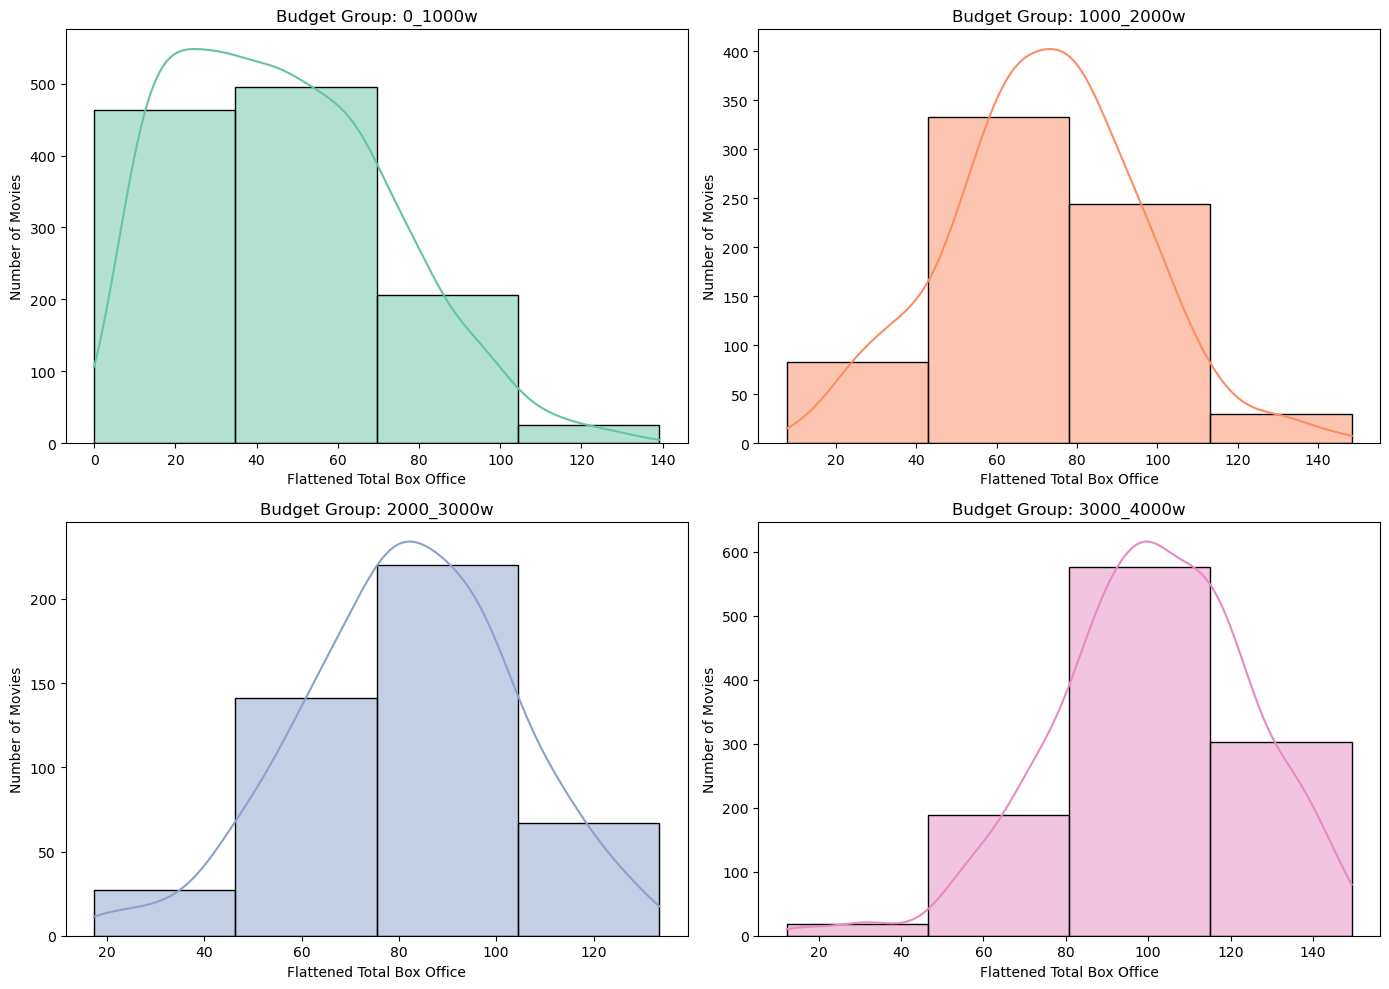

In [194]:
# 畫每個組別的票房分布
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, label in enumerate(['0_1000w', '1000_2000w', '2000_3000w', '3000_4000w']):
    sns.histplot(
        data=grouped_df[label],
        x='flattened_total_box_office',
        bins=4,
        kde=True,
        ax=axes[i],
        color=sns.color_palette("Set2")[i]
    )
    axes[i].set_title(f"Budget Group: {label}")
    axes[i].set_xlabel("Flattened Total Box Office")
    axes[i].set_ylabel("Number of Movies")

plt.tight_layout()
plt.show()

In [199]:
# 執行常態檢定
for label, df_group in grouped_df.items():
    x = df_group["flattened_total_box_office"]
    print(x.min())

    # Shapiro-Wilk test
    s_stat, s_p = stats.shapiro(x)

    # Chi-square test
    try:
        c_stat, c_p = chi_square_normality_test(x, 4)
        chi_msg = f"χ² = {c_stat:.4f}, p = {c_p:.4f} → {'常態' if c_p > 0.05 else '不常態'}"
    except ValueError as e:
        chi_msg = f"Chi-square 檢定失敗：{e}"

    print(f"\n預算組別：{label}")
    print(f"Shapiro-Wilk  : W = {s_stat:.4f}, p = {s_p:.4f} → {'常態' if s_p > 0.05 else '不常態'}")
    print(f"Chi-square    : {chi_msg}")

2.2581008643532257

預算組別：0_1000w
Shapiro-Wilk  : W = 0.9721, p = 0.0000 → 不常態
Chi-square    : χ² = 38.2668, p = 0.0000 → 不常態
7.6756233158370755

預算組別：1000_2000w
Shapiro-Wilk  : W = 0.9960, p = 0.0756 → 常態
Chi-square    : χ² = 0.3866, p = 0.9430 → 常態
17.373953766328675

預算組別：2000_3000w
Shapiro-Wilk  : W = 0.9938, p = 0.0618 → 常態
Chi-square    : χ² = 1.6800, p = 0.6414 → 常態
12.213834219018699

預算組別：3000_4000w
Shapiro-Wilk  : W = 0.9906, p = 0.0000 → 不常態
Chi-square    : χ² = 2.4561, p = 0.4833 → 常態


In [196]:
# Extract the values from each group
group_values = [df_group["flattened_total_box_office"].values for df_group in grouped_df.values()]

# Run Bartlett's test
b_stat, b_p = bartlett(*group_values)
bart_msg = f"Bartlett’s test: stat = {b_stat:.4f}, p = {b_p:.4f} → {'變異數相同' if b_p > 0.05 else '變異數不相同'}"
print(bart_msg)

Bartlett’s test: stat = 25.5666, p = 0.0000 → 變異數不相同


In [202]:
excluded_labels = ['1000_2000w', '2000_3000w', '3000_4000w']
excluded_group_values = [
    df["flattened_total_box_office"].values
    for label, df in grouped_df.items()
    if label in excluded_labels
]

# Run Bartlett's test
b_stat, b_p = bartlett(*excluded_group_values)
bart_msg = f"Bartlett’s test: stat = {b_stat:.4f}, p = {b_p:.4f} → {'變異數相同' if b_p > 0.05 else '變異數不相同'}"
print(bart_msg)


Bartlett’s test: stat = 4.7253, p = 0.0942 → 變異數相同


In [76]:
f_test_variances(budget_low, budget_high, sides=2, alpha=0.05)

,0,1
Mean,6.873283e+00,9.823617
Std Dev,2.046081e+00,1.699519
Size,1.520000e+03,2184.000000
Degrees of Freedom,1.519000e+03,2183.000000
F-statistic,1.449417e+00,NaN
F-critical,1.096643e+00,0.911162
p-value,2.442491e-15,NaN


In [162]:
excluded_labels = ['1000_2000w', '2000_3000w', '3000_4000w']
excluded_df = filtered_df[filtered_df['budget_group'].isin(excluded_labels)]
display(filtered_df.loc[:, filtered_df.columns.isin(['production_budget', 'budget_group'])])


,production_budget,budget_group
1,185000000,NaN
3,70000000,NaN
6,225000000,NaN
7,139000000,NaN
8,210000000,NaN
...,...,...
20795,40000000,3000_4000w
21315,650000,NaN
21560,1660000,NaN
21961,10300000,1000_2000w


In [203]:
oneway_anova(excluded_df, 'flattened_total_box_office', 'budget_group')


ANOVA Table:


,sum_sq,df,F,PR(>F)
C(budget_group),9.278347e+06,3.0,5584.225091,0.0
Residual,8.141488e+05,1470.0,NaN,NaN


In [204]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_src = pairwise_tukeyhsd(
    endog=excluded_df['flattened_total_box_office'],
    groups=excluded_df['budget_group'],
    alpha=0.05
)
print("Tukey HSD for Source:")
print(tukey_src.summary())

Tukey HSD for Source:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
1000_2000w 2000_3000w   9.9431   0.0   6.611 13.2753   True
1000_2000w 3000_4000w  18.4972   0.0 14.7905  22.204   True
2000_3000w 3000_4000w   8.5541   0.0  4.5532  12.555   True
-----------------------------------------------------------


In [77]:
t_test_summary(budget_low, budget_high, usevar='unequal', alpha=0.05)

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,-2.9503,0.064,-46.208,0.000,-3.076,-2.825
